In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import os
import sys
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt


HOME = Path(os.getcwd()).parents[0]

sys.path.insert(1, str(HOME))

from dsrnngan import data,  utils, setupdata, read_config, plots
from dsrnngan.noise import NoiseGenerator

In [15]:
gen = setupdata.load_model_from_folder(model_folder='/user/home/uz22147/logs/cgan/d34d309eb0e00b04', model_number=38400)

records_folder = '/user/work/uz22147/tfrecords/d34d309eb0e00b04/'
data_gen_train, data_gen_valid = setupdata.load_data_from_folder('/user/work/uz22147/tfrecords/d34d309eb0e00b04/')

config = read_config.read_config(os.path.join(records_folder, 'local_config.yaml'))
latitude_range, longitude_range = read_config.get_lat_lon_range_from_config(config)

setting up inputs
generator_input shape: (None, None, None, 20)
constants_input shape: (None, None, None, 2)
upscaled constants shape: (None, None, None, 64)
noise_input shape: (None, None, None, 4)
Shape after first concatenate: (None, None, None, 88)
End of first residual block
Shape after first residual block: (None, None, None, 64)
Shape after upsampling step 1: (None, None, None, 64)
Shape after residual block: (None, None, None, 64)
Shape after second concatenate: (None, None, None, 66)
Shape after third residual block: (None, None, None, 64)
Output shape: (None, None, None, 1)
generator_input shape: (None, None, None, 20)
constants_input shape: (None, None, None, 2)
generator_output shape: (None, None, None, 1)
upscaled constants shape: (None, None, None, 256)
Shape after lo-res concatenate: (None, None, None, 276)
Shape after hi-res concatenate: (None, None, None, 3)
Shape of lo-res input after residual block: (None, None, None, 512)
Shape of hi_res_input after upsampling step 

100%|██████████| 10/10 [00:46<00:00,  4.63s/it]


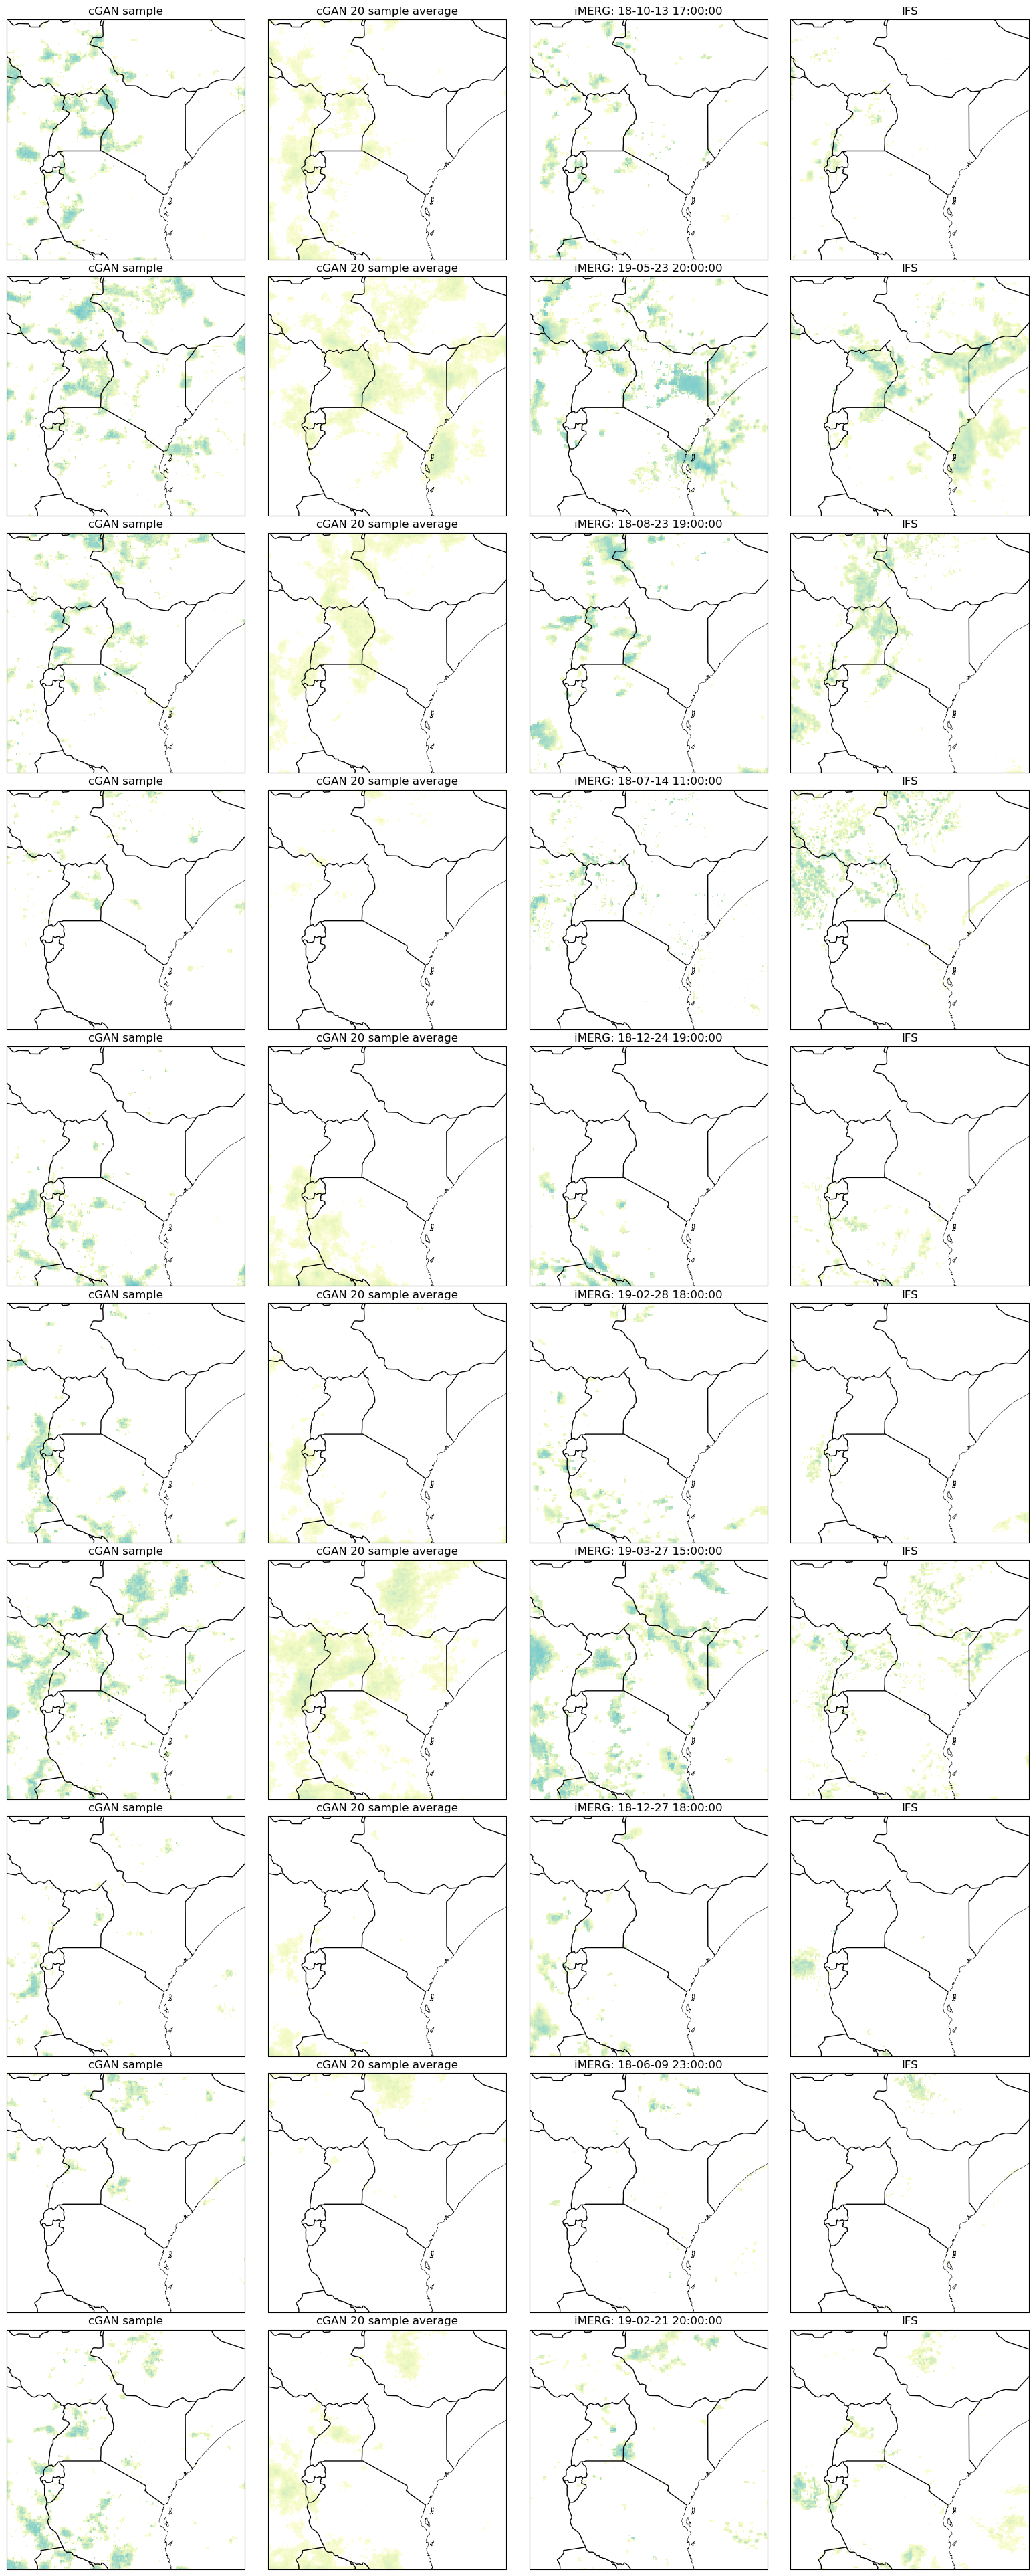

In [16]:
import os
import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colorbar, colors, gridspec

from dsrnngan import data
from dsrnngan.noise import NoiseGenerator
from dsrnngan.rapsd import plot_spectrum1d, rapsd
from dsrnngan.thresholded_ranks import findthresh
from dsrnngan.plots import plot_img_log_coastlines
import copy

denormalise_data = True
batch_gen_iter = iter(data_gen_valid)
noise_channels = config['GENERATOR']['noise_channels']

tp_index = data.all_ifs_fields.index('tp')

# plot configurations

spacing = 10
units = "Rain rate [mm h$^{-1}$]"
cb_tick_loc = np.array([0.1, 0.5, 1, 2, 5, 15, 30, 50])
cb_tick_labels = [0.1, 0.5, 1, 2, 5, 15, 30, 50]
value_range_precip=(0.1, 30)
num_samples = 10
num_rows = num_samples
num_cols = 4
ensemble_size = 20

figsize = (num_cols*5, num_rows*5)
fig = plt.figure(figsize=figsize)

gs = gridspec.GridSpec(spacing*num_rows+1, spacing*num_cols, wspace=0.5, hspace=2)

for n in tqdm(range(num_samples)):
    
    img_gens, truth, fcst, dates, hours = setupdata.generate_prediction(batch_gen_iter, 
                                                                        gen, noise_channels, 
                                                                        batch_size=1, denormalise_data=False,
                                                                        ensemble_size=ensemble_size)
    avg_img_gens = np.add.reduce([item[0, :, :,0] for item in img_gens]) / len(img_gens)
    date_str = dates[0].strftime('%y-%m-%d') + f' {hours[0]}:00:00'
    
    # cGAN
    data_lookup = {'cGAN sample': img_gens[0][0, :, :, 0],
                   f'cGAN {ensemble_size} sample average': avg_img_gens,
                   f"iMERG: {date_str}": truth[0, :,:,0],
                   'IFS': fcst[0, :, :, tp_index]
                   }
    for k, (title, data) in enumerate(data_lookup.items()):
   
        plt.subplot(gs[(spacing*n):(spacing+spacing*n), (spacing*k):(spacing+spacing*k)],
                            projection=ccrs.PlateCarree())
        ax = plt.gca()
        plots.plot_precipitation(ax, data, value_range_precip)
        ax.set_title(title)
 
plt.savefig('cGAN_samples_IFS.png')

In [65]:
# Calculate correlations

from dsrnngan import data
from datetime import datetime, timedelta

records_folder = '/user/work/uz22147/tfrecords/d34d309eb0e00b04/'
config = read_config.read_config(os.path.join(records_folder, 'local_config.yaml'))

latitude_range, longitude_range = read_config.get_lat_lon_range_from_config(config)

num_samples = 10
ensemble_size = 2
ens_mean_gen_list = []
truth_list = []
fcst_list = []
persisted_list = []

batch_gen_iter = iter(data_gen_valid)

for n in tqdm(range(num_samples)):
    
    img_gens, truth, fcst, dates, hours = setupdata.generate_prediction(batch_gen_iter, 
                                                                        gen, noise_channels, 
                                                                        batch_size=1, denormalise_data=False,
                                                                        ensemble_size=ensemble_size)
    avg_img_gens = np.add.reduce([item[0, :, :,0] for item in img_gens]) / len(img_gens)
    
    ens_mean_gen_list.append(avg_img_gens)
    truth_list.append(truth[0,:,:, 0])
    fcst_list.append(fcst[0, :, :, 0])
    
    # load imerg from that day / hour to check persistent forecast
    dt = datetime(dates[0].year, dates[0].month, dates[0].day, hours[0]) - timedelta(hours=12)
    imerg_persisted = data.load_imerg(dt.date(), hour=dt.hour,
               latitude_vals=latitude_range, longitude_vals=longitude_range,
               log_precip=config['DATA']['log_precip'])
    
    persisted_list.append(imerg_persisted)
    

100%|██████████| 10/10 [00:21<00:00,  2.14s/it]


In [66]:
fcst_vals = np.concatenate(fcst_list).flatten()
truth_vals = np.concatenate(truth_list).flatten()
gan_vals = np.concatenate(ens_mean_gen_list).flatten()
persisted_vals = np.concatenate(persisted_list).flatten()

In [68]:


print(calculate_pearsonr(gan_vals, truth_vals))
print(calculate_pearsonr(fcst_vals, truth_vals))
print(calculate_pearsonr(persisted_vals, truth_vals))
print(calculate_pearsonr(truth_vals, truth_vals))

PearsonRResult(statistic=0.1764482196254153, pvalue=0.0)
PearsonRResult(statistic=-0.03275121274796585, pvalue=7.933684708195778e-96)
PearsonRResult(statistic=0.05405854897075022, pvalue=7.855491730870533e-258)
PearsonRResult(statistic=1.0, pvalue=0.0)


In [47]:
np.sqrt(((truth_vals - fcst_vals)**2).mean())

0.9142761039183758

In [48]:
np.sqrt(((truth_vals - gan_vals)**2).mean())

0.14081973